preprocessing of marks and trajectory to make polygons (and preprocessed trajectory)

analysis of trajectory: not important. actual analysis of trajectory is in polygons_data_preprocessing_marks.ipynb 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
import seaborn as sns
from statistics import mean 
import cv2
import pickle

ImportError: DLL load failed while importing cv2: Не найден указанный модуль.

In [2]:
# !!!!!!!!!!!!!!!!
#  if you already have saved dfs_splited_isnear_marks skip steps 0-4, make steps 5-8, skip steps 9-10, 
#  continue from the step 11
# !!!!!!!!!!!!!!!!

In [2]:
#0. open preprocessed trajectory data
#паузы исправлены
nam = 'preprocessed_dataset/preprocessed_dfs_subtraj_for_marks.pkl'
with open(nam, 'rb') as fp:
    dfs_dict = pickle.load(fp)

In [4]:
# #откроем словарь 0.3 с чтобы были 0.3 с и сразу смерджим его
# with open('preprocessed_dfs_subtraj_0.3s.pkl', 'rb') as fp:
#     dfs_03 = pickle.load(fp)

# # merge dfs of each mouse
# #dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
# #the first row from each df is deleted because it has V=0
# merg_dfs_03 = {}

# for k, df in dfs_03.items():
#     df = [df0.iloc[1:].reset_index() for df0 in df]
#     merg_dfs_03[k] = pd.concat(df)
#     merg_dfs_03[k] = merg_dfs_03[k].reset_index(drop=True)

In [5]:
#графики остановок старого кода
# for i in range(len(names)):
#     plt.figure()
#     plotPauses(dfs[i])
#     plt.title(names[i])

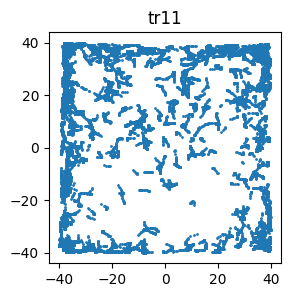

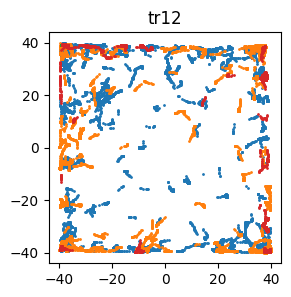

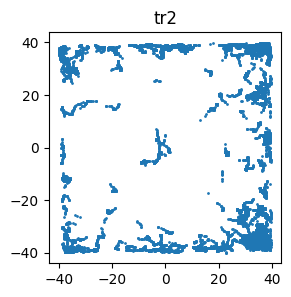

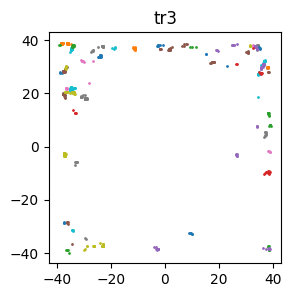

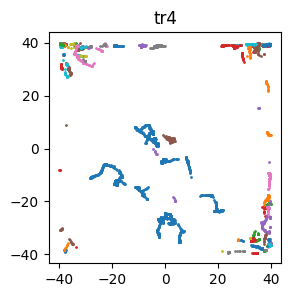

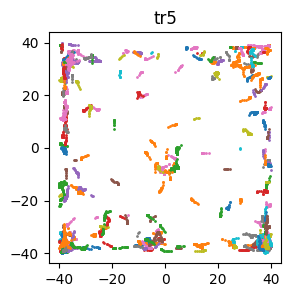

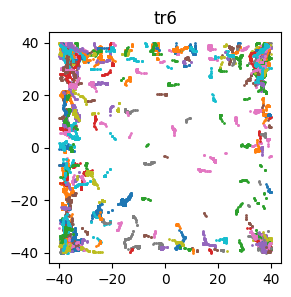

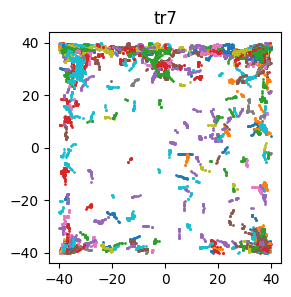

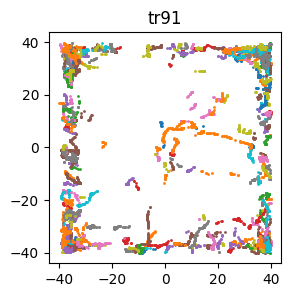

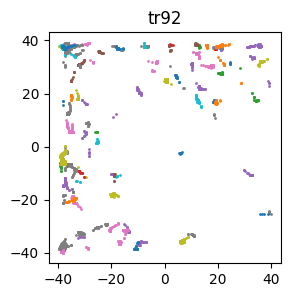

In [6]:
# (optional) 1. нарисуем точки, в которых мышь останавливалась
for k, df in dfs_dict.items():
    plt.figure(figsize=(3, 3))
    plt.title(k)
    for ldf in df:
        n_ldf = ldf.loc[ldf['movement']=='Stop']
        plt.scatter(n_ldf['x'], n_ldf['y'], s=1)
    plt.show()

In [7]:
from utils.processing import add_filtered_V

for k, df in dfs_dict.items():
    sub_list = []
    i = 0
    for ldf in df:
        ldf = ldf.reset_index(drop=True)
        ldf = add_filtered_V(ldf)
        sub_list.append(ldf)
    dfs_dict[k] = sub_list

In [8]:
#3. merge dfs of 1 mouse

# merge dfs of each mouse
#dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
#the first row from each df is deleted because it has V=0
merg_dfs_dict = {}

for k, df in dfs_dict.items():
    df = [df0.iloc[1:].reset_index() for df0 in df]
    merg_dfs_dict[k] = pd.concat(df)
    merg_dfs_dict[k] = merg_dfs_dict[k].reset_index(drop=True)

In [9]:
##4. split the table by time
start_end = {
'tr3': [1.268, 1567.099],
'tr5': [1.068, 1754.786],
'tr6': [1.068, 1662.261],
'tr7': [1.068, 1635.601],
'tr91': [1.068, 1463],
'tr92': [1.068, 645] }
#некоторые мыши (91, 92) под конец записи сидят на 1 месте
#может лучше в словарь запихнуть только используемых мышей

used_mice = ['tr3','tr5','tr6','tr7','tr91']

In [10]:
from utils.processing import cut_df

n_to_split = 3
splited_dfs = {}
for m in used_mice:
    splited_dfs[m] = cut_df(merg_dfs_dict[m], n_to_split,
                            start_end[m][0], start_end[m][1])

### строим метки

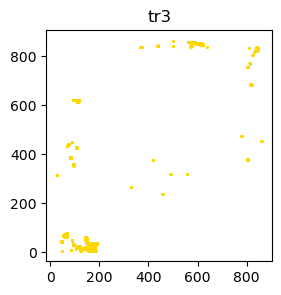

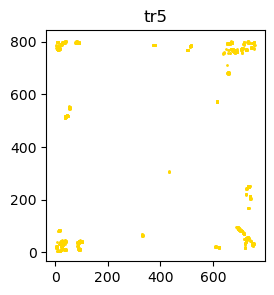

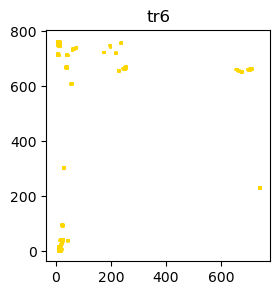

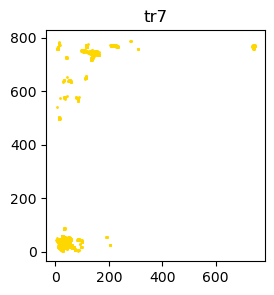

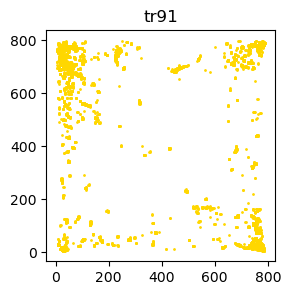

In [4]:
#5 из считанной картинки с метками делаем таблицу с координатами помеченных пикселей
# теперь метки сразу расположены правильно, как и траектории
def RedDFFromIm(im, k=''):
    coords = []
    #так, я поменяла местами х и у и соответсвенно хмакс умакс
    #вернула как было
    xmax = im.shape[0]
    ymax = im.shape[1]
    for i in range(len(im)):
        for j in range(len(im[i])):
            if (int(im[i][j][2]) - int(im[i][j][0]) > 15) and (int(im[i][j][2]) - int(im[i][j][0]) > 15):
                coords.append([i,j,im[i][j][2],im[i][j][1],im[i][j][0]])
    df = pd.DataFrame(coords, columns =['y', 'x', 'red', 'green', 'blue'])
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.set_aspect('equal', adjustable='box')
    plt.title(k)
    plt.plot(df['x'], df['y'],'o', markersize=1, color='gold')
    plt.show()
    marks = {'df':df, 'xmax':xmax, 'ymax':ymax}
    return(marks)

IMG_DIR = 'marks_orig_pictures'
marks = {}
used_mice = ['tr3','tr5','tr6','tr7','tr91']  # 'tr92'
img_names = ['mark_3', 'mark_5', 'mark_6', 'mark_7', 'mark_9.1',]  # 'mark_9.2'

for tr_nam, img_nam in zip(used_mice, img_names):
    im = cv2.imread(f"{IMG_DIR}/{img_nam}.png")
    marks[tr_nam] = RedDFFromIm(im, tr_nam)

In [5]:
from utils.processing import rescale_coord

# 6. переводим метки и траектории в 1 координаты
rescaled_marks = {}
AREA_SIZE = [-40, 40]
for k, df in marks.items():
    rescaled_x = rescale_coord(df['df']['x'].to_numpy(),
                               AREA_SIZE[0], AREA_SIZE[1])
    rescaled_y = rescale_coord(df['df']['y'].to_numpy(),
                               AREA_SIZE[0], AREA_SIZE[1])
    df_ = pd.DataFrame({'x': rescaled_x, 'y': rescaled_y})
    rescaled_marks[k] = df_

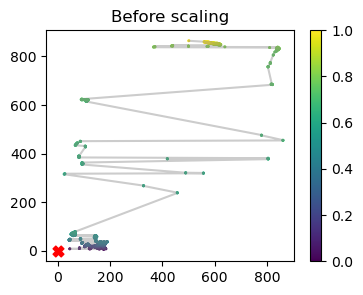

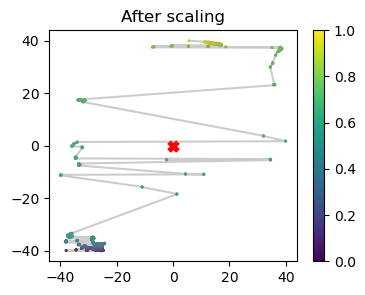

In [6]:
from utils.plotting import plot_trajectory

plt.figure(figsize=(4, 3))
plt.title('Before scaling')
plot_trajectory(marks['tr3']['df']['x'],
                marks['tr3']['df']['y'])

plt.figure(figsize=(4, 3))
plt.title('After scaling')
plot_trajectory(rescaled_marks['tr3']['x'],
                rescaled_marks['tr3']['y'])

NameError: name 'merg_dfs_dict' is not defined

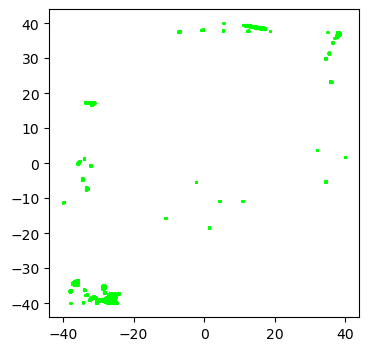

In [7]:
#вроде так верно
plt.figure(figsize=(4, 4))
plt.scatter(rescaled_marks['tr3']['x'], rescaled_marks['tr3']['y'],
            c='lime', s=1.5, zorder=1)
plt.plot(merg_dfs_dict['tr3']['x'], merg_dfs_dict['tr3']['y'],
         c='bisque', zorder=0)
plt.title('tr3')

In [15]:
#метки и остановки
for k, df_n in splited_dfs.items():
    df = df_n[2]  # take the last 1/3 part
    df_stop = df.loc[df['movement']=='Stop']
    plt.figure(figsize=(3, 3))
    plt.scatter(df_stop['x'], df_stop['y'], c='k', s=2,
                label='stops')
    plt.scatter(rescaled_marks[k]['x'],
                rescaled_marks[k]['y'],
                c='greenyellow', alpha=0.2, s=2,
                label='marks')
    plt.title(k)
    plt.legend()
    plt.show()

NameError: name 'splited_dfs' is not defined

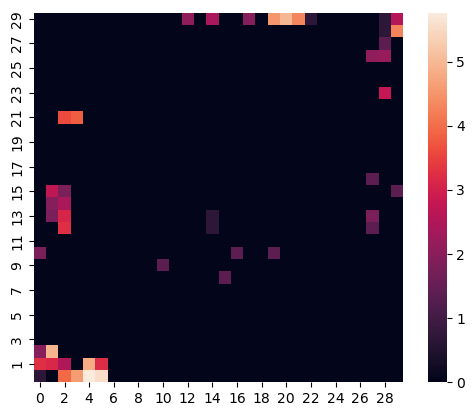

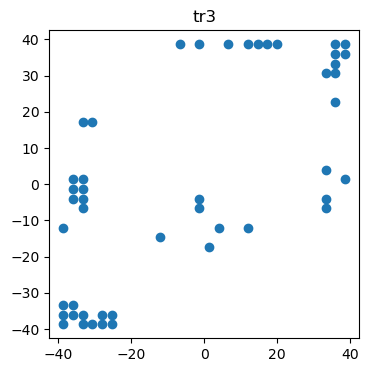

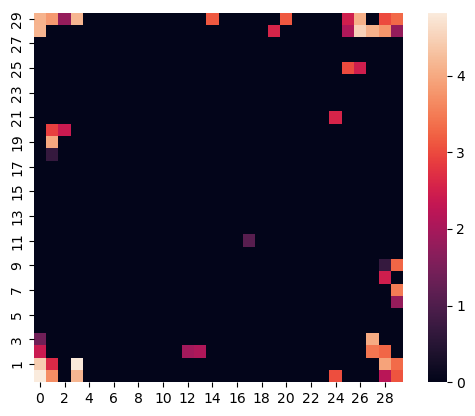

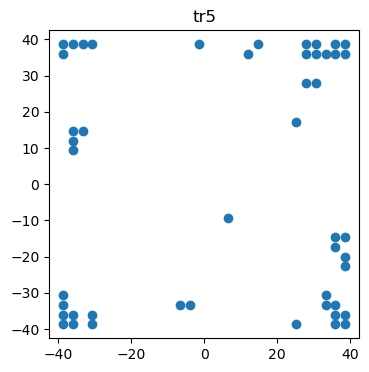

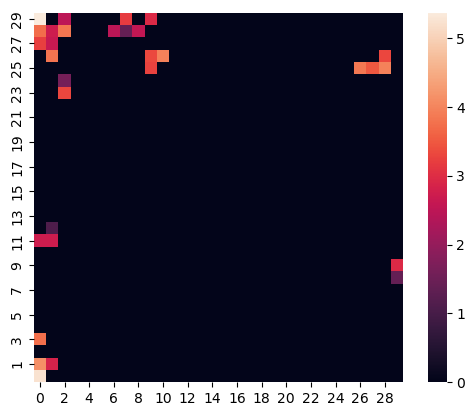

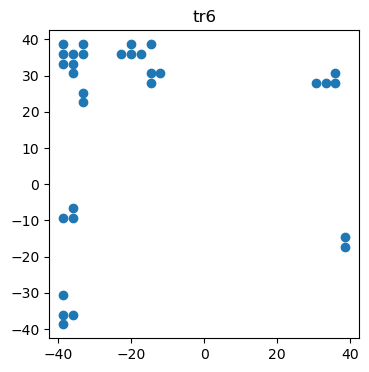

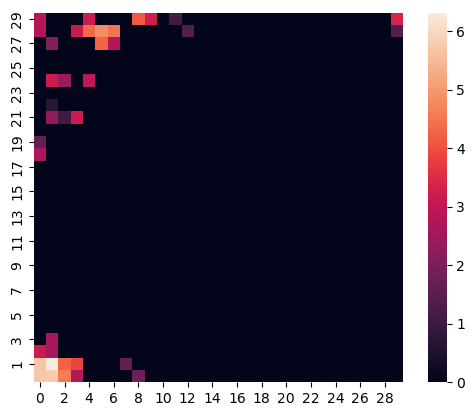

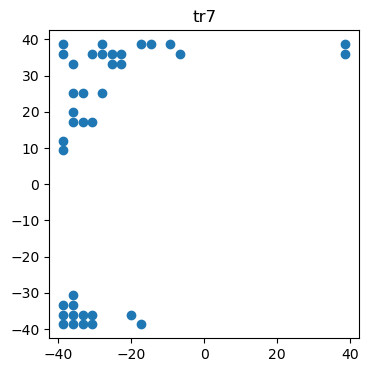

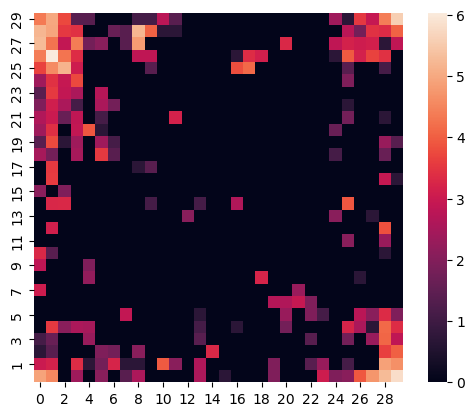

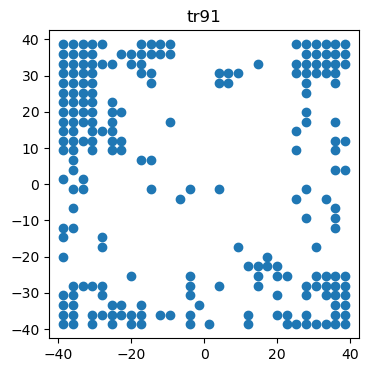

In [9]:
#7 функция окууп карта меток dfHM
#parameter to change!!!!! n
# тут, может есть лишние вращения, но изначально (до этого шага) и в результате этого шага все расположено правильно, 
# в единой системе координат
#поч немного поменялось расположение меток, наверное, были смещены границы/бины
from utils.processing import df_minmax

METKA_THRESH = 0.4
BINN = 30
SCALING = 'log'

def make_occup_map(df, n=20, eps=1e-3, scaling='sqrt', show=True):
    """
    на вход нужна таблица с time x y 
    """
    binx = np.linspace(AREA_SIZE[0]-eps, AREA_SIZE[1]+eps, n+1)
    x_cut = pd.cut(df['x'], binx, right=False)
    biny = np.linspace(AREA_SIZE[0]-eps, AREA_SIZE[1]+eps, n+1)
    y_cut = pd.cut(df['y'], biny, right=False)
    
    dfn = df.groupby([x_cut, y_cut], observed=False).count()
    dfn = dfn.drop(columns=['x', 'y'])

    L = [(a.mid, b.mid) for a, b in dfn.index]
    dfm = dfn.set_index(pd.MultiIndex.from_tuples(L, names=dfn.index.names))

    dd = dfm.unstack()
    if scaling=='sqrt':
        arrd = dd.replace(0, 1e-2).to_numpy()
        arrsrsr = np.sqrt(np.sqrt(np.sqrt(arrd)))
    elif scaling=='log':
        arrd = dd.replace(0, 1).to_numpy()
        arrsrsr = np.log(arrd)
    elif scaling==None:
        arrd = dd.replace(0, 1e-2).to_numpy()
        arrsrsr = arrd
         
    kk = pd.DataFrame(arrsrsr)
    kk = kk.transpose()
    kk = kk.iloc[::-1]  # rotate occupancy map
    if show:
        sns.heatmap(kk, square=True)
    return kk, binx, biny

#8 делаем координаты новых "меток" - центров квадратов, в которых достаточно много меток
def heat_maps_with_coords(marksN, tit='', show=True):
    
    # 1. build occupation (heat) map of marks
    dfHM, binx, biny = make_occup_map(marksN, n=BINN, scaling='log') 
    
    # 2. occ map in which indices are coordinates
    binxmid, binymid = [], []
    for i in range(1, len(binx)):
        binxmid.append((binx[i] + binx[i-1]) / 2)
        binymid.append((biny[i] + biny[i-1]) / 2)
    dfHM.index = binxmid[::-1]
    dfHM.columns = binymid

    # 3. take coordinates of cells with sufficient amount of urine marks 
    # координаты меток т.е. i это y (row) а j это x (column)
    # parameter to change 0.3
    trN_coords, trN_coeff = [], []
    for i in range(dfHM.shape[0]-1, -1, -1):
        for j in range(dfHM.shape[1]):
            if dfHM.iloc[i, j] > METKA_THRESH:
                trN_coords.append((dfHM.columns[j], dfHM.index[i]))
                trN_coeff.append((dfHM.iloc[i, j]))
    if show:
        plt.figure(figsize=(4, 4))
        trN_coords_x = [i[0] for i in trN_coords]
        trN_coords_y = [i[1] for i in trN_coords]
        plt.scatter(trN_coords_x, trN_coords_y)
        plt.title(tit)
        plt.show()

    return trN_coords, trN_coeff

hm_marks_coords = {}
hm_marks_coeff = {}
for n in used_mice:
    df = rescaled_marks[n]
    df['c'] = np.ones((rescaled_marks[n].shape[0])) # instead of time

    marks_coords, mark_coeff = heat_maps_with_coords(df, tit=n)
    hm_marks_coords[n] = marks_coords
    hm_marks_coeff[n] = mark_coeff

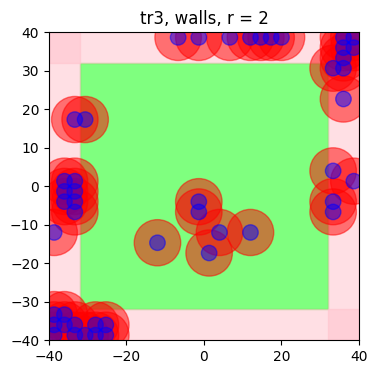

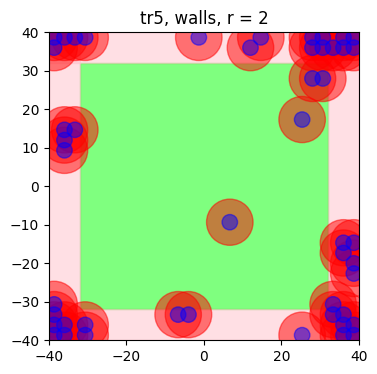

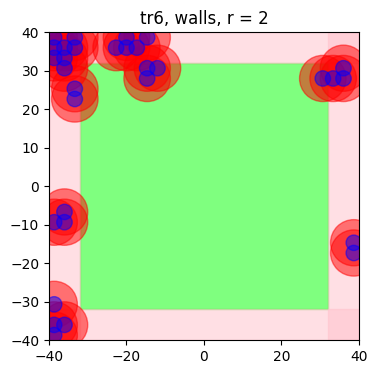

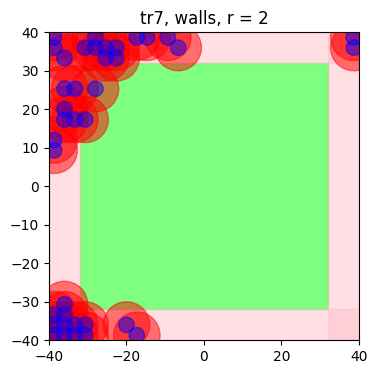

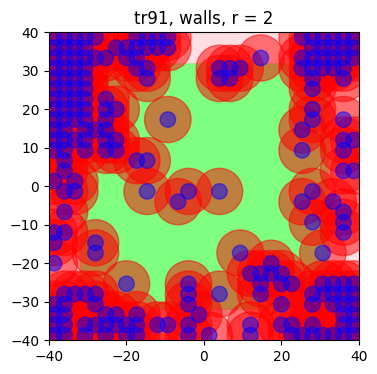

In [17]:
#9. (additional) make pictures to compare areas of marks surroundings vs regular space
r1 = 2
r2 = 3 * r1

for n in used_mice:
    fig, ax = plt.subplots(figsize=(4, 4))
    square = Rectangle((-32, -32), 64, 64, color=(0, 1, 0),
                           alpha=0.5)
    ax.add_patch(square)

    squares = [Rectangle((-40, -40), 8, 80),
               Rectangle((32, -40), 8, 80),
               Rectangle((-40, -40), 80, 8),
               Rectangle((-40, 32), 80, 8)]
    sq = PatchCollection(squares, alpha=0.5, color='pink')
    ax.add_collection(sq)

    # TODO: add corners
    
    for r, col in zip([r2, r1], ['red', 'blue']):
        patches = []
        coords = hm_marks_coords[n]
        for c in coords:
            circle = Circle((c[0], c[1]), r)
            patches.append(circle)
        p = PatchCollection(patches, color=col, alpha=0.5)
        ax.add_collection(p)

    plt.xlim(-40, 40)
    plt.ylim(-40, 40)
    name = n + ', walls' + ', r = ' + str(r)
    plt.title(name)
    plt.show()
    # break

In [18]:
#10. размечаем в таблице траектории какие точки находятся в окрестностях r1 и r2 меток, а какие нет
def calc_marks_masks(trN, trN_marks_coords, r1=2, r2=6):
    trN_marks_coords = np.asarray(trN_marks_coords)
    x_metki = trN_marks_coords[:, 0][..., np.newaxis]
    y_metki = trN_marks_coords[:, 1][..., np.newaxis]

    xm = np.tile(trN['x'].values, (x_metki.shape[0], 1))
    ym = np.tile(trN['y'].values, (y_metki.shape[0], 1))

    # shape: [num_metki, num_points]
    dist = ((xm - x_metki)**2 + (ym - y_metki)**2)**0.5  
    mask_r1 = dist <= r1
    mask_r2 = dist <= r2

    # plt.figure(figsize=(14, 10))  # TODO: you can look at the timeline
    # plt.imshow(mask_r1*1)
    # plt.show()
    # plt.figure(figsize=(14, 10))
    # plt.imshow(mask_r2*1)
    # plt.show()

    return mask_r1, mask_r2

def add_marks_intersect_times(df, m_r1, m_r2):
    """ 
    adds to df 2 columns: 'r1' and 'r2'
    calculate if a time point in ANY mark
    sum up all intersected marks, so add duplicate in marks clusters
    """
    counts_r1 = np.sum(m_r1*1, axis=0)
    counts_r2 = np.sum(m_r2*1, axis=0)
    # print(np.unique(counts_r1, return_counts=True)) # TODO: u can look at uniqe vals
    # print(np.unique(counts_r2, return_counts=True))
    df_ = df.copy()
    df_['r1'] = counts_r1
    df_['r2'] = counts_r2
    return df_


dfs_splited_isnear_marks = {}
for m in used_mice:
    subtraj_list = []
    for df in splited_dfs[m]:
        m_r1, m_r2 = calc_marks_masks(df, hm_marks_coords[m], r1=2, r2=6)
        subtraj_list.append(add_marks_intersect_times(df, m_r1, m_r2))
        dfs_splited_isnear_marks[m] = subtraj_list

In [19]:
# TODO: 3. просто коэффициент сколько меток по сравнению с общей площадью (в бинах). 
#       N metki bins / N all bins - for each mouse
# TODO: 4. distribure metki in 3 types of areas (corners, walls, center)

# TODO: как статистически доказать что мышь возле стен и мышь возле меток+стен различаются?
#       какие данные брать?
#       1. cравнивать у мышей tr3, tr6, tr7 стены с метками и без (все сэмплы) 
#       по скорости, occupancy, остановкам, 
#              частоту пересечения (the first passage time ??)


# ANALYSIS:
# TODO: is there some difference between parameters of mouse and 3 types of metkas?
# TODO: KATE: 2. plot vector field + metki, occup map + metki
# TODO: frequency of visiting metki (compare with any point in the same area type, e.g. wall)
# TODO: tr3, tr6, tr7 - есть углы без меток?

# TODO: hyperparameters: metki theshhold=0.3, r1, r1, bin of open area, 
# TODO: all the same but for 3 time parts of mouse in the field
# TODO: can we see difference in 1st and 3rd part of recording?

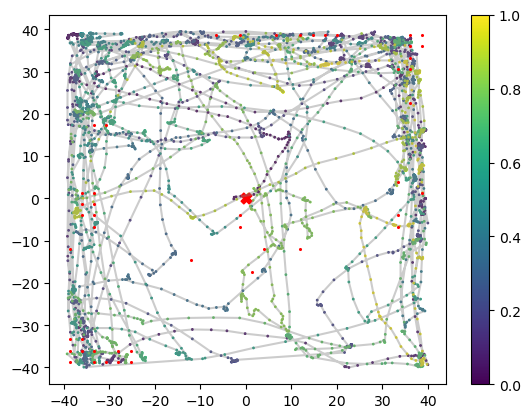

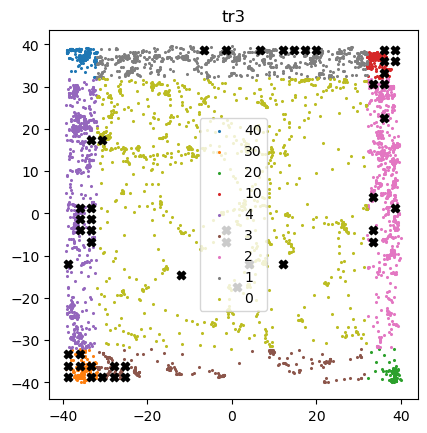

In [14]:
k = 'tr3'

tr1 = pd.concat(dfs_splited_isnear_marks[k])

marks_coords = hm_marks_coords[k] 
mark_coeff = hm_marks_coeff[k] 

m = marks_coords
m = np.asarray(m)
plt.scatter(m[:, 0], m[:, 1], c='red', s=1.5, zorder=27)

plot_trajectory(tr1['x'], tr1['y'])

from utils.plotting import plot_wall_sorted_samples
plt.scatter(m[:, 0], m[:, 1], c='black', zorder=2, marker='X')
plot_wall_sorted_samples(tr1, k)

In [ ]:
# Save distributions
with open('preprocessed_dataset/splited_isnear_marks.pkl', 'wb') as fp:    
    pickle.dump(dfs_splited_isnear_marks, fp)

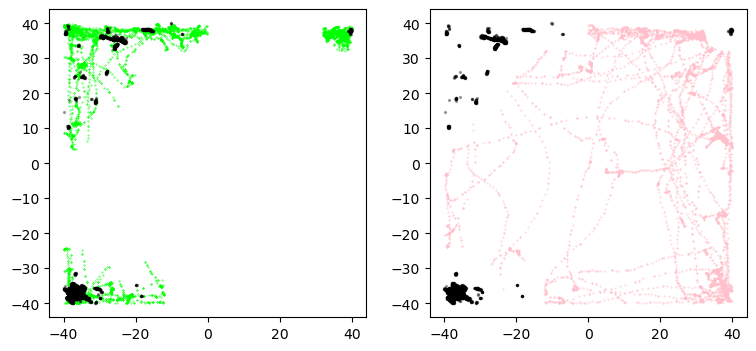

In [13]:
#check surrounding of marks
df = dfs_splited_isnear_marks['tr7'][0]

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
check = df.loc[(df['r2']>0) & (df['r1']>=0)]
ax[0].scatter(check['x'], check['y'], s=0.1, c='lime')
ax[0].scatter(rescaled_marks['tr7']['x'],
              rescaled_marks['tr7']['y'], s=2, c='black', alpha=0.3)

check1 = df.loc[(df['r2']==0) & (df['r1']==0)]
ax[1].scatter(check1['x'], check1['y'], s=0.1, c='pink')
ax[1].scatter(rescaled_marks['tr7']['x'],
              rescaled_marks['tr7']['y'],s=2, c='black', alpha=0.3)
plt.show()

In [16]:
#11. open dfs_splited_isnear_marks if we skipped steps 0-4, 9-10
with open('preprocessed_dataset/splited_isnear_marks.pkl', 'rb') as fp:
    dfs_splited_isnear_marks = pickle.load(fp)

#### Cluster marks and save as df

In [18]:
from utils.plotting import plot_marks_clusters
from utils.processing import cluster_marks
BINN = 30
SCALING = 'log'

MARKS_DIR = 'preprocessed_dataset'
clust_params = {
        'tr3': {'eps': 7, 'min_samples': 1},
        'tr5': {'eps': 5, 'min_samples': 1},
        'tr6': {'eps': 4, 'min_samples': 1},
        'tr7': {'eps': 7, 'min_samples': 1},
        'tr91': {'eps': 5, 'min_samples': 3}}

clustered_marks = {}

for k in hm_marks_coords.keys():
    cparams = clust_params[k]
    marks_coords = hm_marks_coords[k] 
    mark_coeff = hm_marks_coeff[k]   # ~ occup map

    lab = cluster_marks(marks_coords,
                        eps=cparams['eps'],
                        min_samples=cparams['min_samples'],
                        show=False)
    X = np.asarray(marks_coords)
    df_marks = pd.DataFrame(data={'x': X[:, 0],
                                'y': X[:, 1],
                                'coeff': mark_coeff,
                                'cluster': lab})
    clustered_marks[k] = df_marks
    
    savename = f'{MARKS_DIR}/marks_{k}_{BINN}bin_{SCALING}.pkl'
    with open(savename, 'wb') as fp:    # NOTE: uncomment to save
        pickle.dump(df_marks, fp)

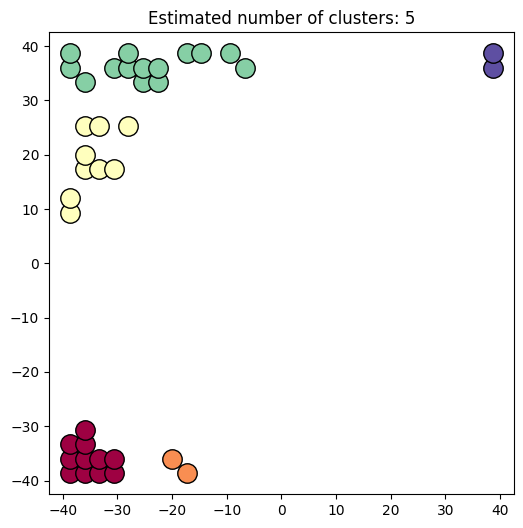

[0 1 2 3 4]


In [21]:
df_marks = clustered_marks['tr7']
X = df_marks[['x', 'y']].to_numpy()
c = df_marks['cluster'].to_numpy()
plot_marks_clusters(X, c)
print(np.unique(c))

#### Define area around marks

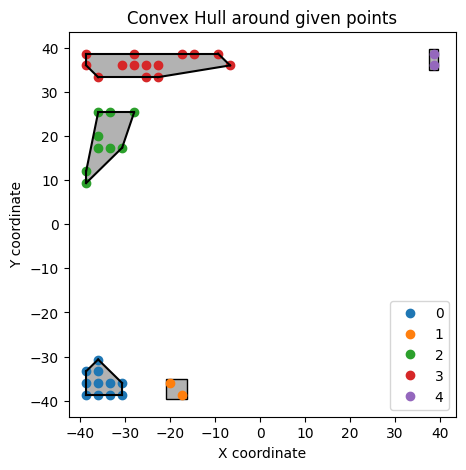

In [22]:
from scipy.spatial import ConvexHull

def plot_bound_box(points, buffer=1.0, lab=None):
    x_min, y_min = points.min(axis=0) - buffer
    x_max, y_max = points.max(axis=0) + buffer

    plt.plot(points[:, 0], points[:, 1], 'o', label=lab)
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     alpha=0.3, facecolor='black'))
    currentAxis.add_patch(Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     edgecolor='black', facecolor='none'))

plt.figure(figsize=(5, 5))

clust_labels = np.unique(c)
for lab in clust_labels:

    points = df_marks[['x', 'y']].loc[df_marks['cluster']==lab].to_numpy()
    if points.shape[0] == 2:
        plot_bound_box(points, lab=lab)
        continue
    plt.plot(points[:, 0], points[:, 1], 'o', label=lab)
    
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'k', alpha=0.3)

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Convex Hull around given points')
plt.legend()
plt.show()

### Switch to shapely

https://shapely.readthedocs.io/en/stable/manual.html

In [23]:
from shapely.geometry import MultiPoint, Polygon

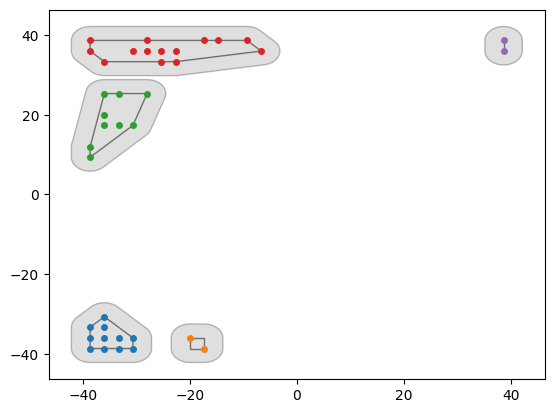

In [24]:
def marks2shapely(df_marks, clust_labels, r=3.5, show=True):
    """
    df_marks: df with marks for a mice. clustered
    clust_labels: unique labels of clusters
    r: buffer zone radius

    return:
    marks_poly_list: a triplet of 
    [a marker cluster polygon, buffer zone and label of a cluster]
    """
    marks_poly_list = []

    for lab in clust_labels:
        points = df_marks[['x', 'y']].loc[df_marks['cluster']==lab].to_numpy()
        points = [(xy[0], xy[1]) for xy in points]

        if len(points) == 2:
            point1, point2 = points[0], points[1]
            point3, point4 = (point1[0], point2[1]), (point2[0], point1[1])
            convex_hull_polygon = Polygon([point1, point3,
                                           point2, point4])
        else: 
            multi_point = MultiPoint(points)
            convex_hull_polygon = multi_point.convex_hull
        # Create a buffer
        zone_polygon = convex_hull_polygon.buffer(r)
        marks_poly_list.append([convex_hull_polygon, zone_polygon, lab])
        if show:
            x_zone, y_zone = zone_polygon.exterior.xy
            plt.fill(x_zone, y_zone, alpha=0.25, linewidth=1, linestyle='-',
                    edgecolor='black', facecolor='gray', label='Zone Polygon')

            x, y = convex_hull_polygon.exterior.xy
            plt.fill(x, y, alpha=0.5, linewidth=1, linestyle='-',
                    facecolor='none', edgecolor='black', label='')
            plt.plot(*zip(*points), marker='o', ls='',
                    markersize=4.)
    if show:       
        plt.show()
    
    return marks_poly_list

# df_marks = clustered_marks['tr7']
# X = df_marks[['x', 'y']].to_numpy()
# c = df_marks['cluster'].to_numpy()
# plot_marks_clusters(X, c)
# print(np.unique(c))
clust_labels = np.unique(c)
marks_poly_list = marks2shapely(df_marks, clust_labels)

In [25]:
# trajs_k = ['tr3', 'tr5', 'tr6', 'tr7', 'tr91']
# k = 'tr7'
# tr = pd.concat(dfs_splited_isnear_marks[k])

# points = tr[['x', 'y']].to_numpy()
# trajectory_points = [(xy[0], xy[1]) for xy in points]
# trajectory = LineString(trajectory_points)
# print(trajectory.length)

# plt.figure(figsize=(7, 7))
# marks_interections = []
# for polygon, poly_buffer, lab in marks_poly_list:
#     intersection = polygon.intersection(trajectory)
#     if intersection.is_empty:
#         print("The trajectory does not intersect with the polygon.")
#     else:
#         marks_interections.append([intersection, lab])
#         if not intersection.is_empty:
#             if intersection.geom_type == 'MultiLineString':
#                 for geom in intersection.geoms:
#                     x, y = geom.xy
#                     plt.plot(x, y, color='red', linewidth=1.5,
#                             alpha=0.2, zorder=4)
#             elif intersection.geom_type == 'LineString':
#                 x, y = intersection.xy
#                 plt.plot(x, y, color='red', linewidth=1.5,
#                          alpha=0.2, label='Intersection', zorder=4)
#     # plot mark poly + buffer
#     x_zone, y_zone = poly_buffer.exterior.xy
#     plt.fill(x_zone, y_zone, alpha=0.25, linewidth=1, linestyle='-',
#                 edgecolor='black', facecolor='gray', label='Zone Polygon')
#     x_poly, y_poly = polygon.exterior.xy
#     plt.fill(x_poly, y_poly, alpha=0.25, linewidth=1, linestyle='-',
#                 facecolor='blue', edgecolor='black', label='')
#     break
# x, y = trajectory.xy
# plt.plot(x, y, color='grey', linewidth=2, label='Trajectory', alpha=0.5)
# plt.plot(x, y, color='black',  marker='o', ls='', markersize=0.3, alpha=0.5)

# plt.show()

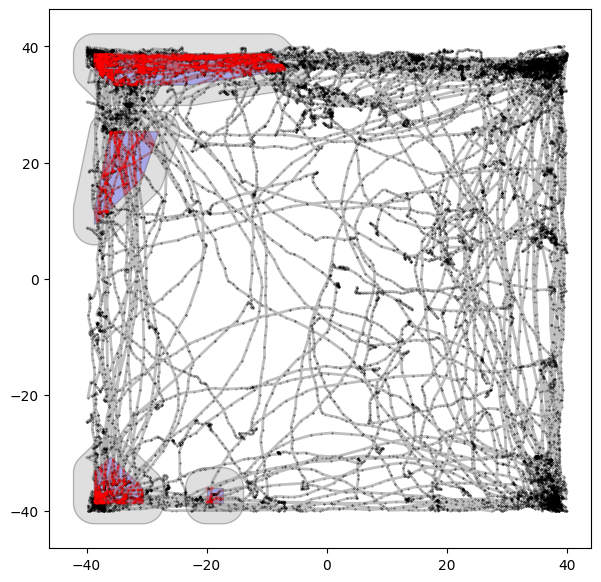

In [26]:
from shapely.geometry import LineString, MultiLineString


def plot_intersected_element(intersection):
    if intersection.geom_type == 'MultiLineString':
        for geom in intersection.geoms:
            x, y = geom.xy
            plt.plot(x, y, color='red', linewidth=1.5,
                    alpha=0.2, zorder=4)
    elif intersection.geom_type == 'LineString':
        x, y = intersection.xy
        plt.plot(x, y, color='red', linewidth=1.5,
                alpha=0.2, label='Intersection', zorder=4)


def plot_shapely_traj(trajectory):
    x, y = trajectory.xy
    plt.plot(x, y, color='grey', linewidth=2,
             label='Trajectory', alpha=0.5)
    plt.plot(x, y, color='black',  marker='o', ls='',
             markersize=0.3, alpha=0.5)


def plot_shapely_marks(polygon, poly_buffer):
    # plot mark poly + buffer
    x_zone, y_zone = poly_buffer.exterior.xy
    plt.fill(x_zone, y_zone, alpha=0.25, linewidth=1, linestyle='-',
                edgecolor='black', facecolor='gray', label='Zone Polygon')
    x_poly, y_poly = polygon.exterior.xy
    plt.fill(x_poly, y_poly, alpha=0.25, linewidth=1, linestyle='-',
                facecolor='blue', edgecolor='black', label='')


def find_traj_marks_intersections(tr, marks_poly_list, show=True):
    """
    tr: df with trajectory and x,y coordinates
    marks_poly_list: 
    """
    points = tr[['x', 'y']].to_numpy()
    trajectory_points = [(xy[0], xy[1]) for xy in points]
    trajectory = LineString(trajectory_points)

    plt.figure(figsize=(7, 7))
    marks_interections = []
    for polygon, poly_buffer, lab in marks_poly_list:

        intersection = polygon.intersection(trajectory)
        intersection_buffer = poly_buffer.intersection(trajectory)
        marks_interections.append([intersection, intersection_buffer, lab])

        # plotting traj, marks and intersections
        if not intersection.is_empty and show:
            plot_intersected_element(intersection)
            plot_shapely_marks(polygon, poly_buffer)
    if show:
        plot_shapely_traj(trajectory)
        plt.show()

    return marks_interections


k = 'tr7'
tr = pd.concat(dfs_splited_isnear_marks[k])
marks_interections = find_traj_marks_intersections(tr, marks_poly_list)

In [53]:
# Now we have to do extractor of trajectory back to df to calc different stats
def extract_shapely_intersections(tr, marks_interections, buff=False,
                                  eps = 0.05, show=True):
    tr['intersection'] = 0.
    df_inters_marks = {}
    for intersection, intersection_buff, lab in marks_interections:

        # choose poly_buffer or poly
        intersection = intersection_buff if buff else intersection

        if isinstance(intersection, LineString):
            intersecting_points = list(zip(*intersection.xy))
        elif isinstance(intersection, MultiLineString):
            intersecting_points = [list(zip(*geom.xy)) for geom in intersection.geoms]
            intersecting_points = [point for sublist in intersecting_points for point in sublist]

        indexes = []
        for point in intersecting_points:
            matches = tr[(tr['x'] > point[0]-eps) & (tr['x'] < point[0]+eps) & \
                        (tr['y'] > point[1]-eps) & (tr['y'] < point[1]+eps)]
            indexes.extend(matches.index.tolist())

        # Take uniques idxs
        u_idx = np.sort(np.unique(np.asarray(indexes)))
        print("Unique intersecting points in DataFrame:", len(u_idx)) 
        print(f'Total ratio: {round(len(u_idx) / len(tr), 3)}')

        # Extract from df trajectory parts
        df_inters = tr.loc[u_idx]
        df_inters_marks[lab] = df_inters
            
        # Note intersections in original df
        tr.loc[u_idx, ['intersection']] = lab        

        if show:
            plot_trajectory(df_inters['x'], df_inters['y'],
                            center_mark=False)

    return df_inters_marks, tr


k = 'tr7'
tr = pd.concat(dfs_splited_isnear_marks[k])

# df for 1 traj with marks 
df_intersecting, tr_new = extract_shapely_intersections(tr, marks_interections)

Unique intersecting points in DataFrame: 1229
Total ratio: 0.027


TypeError: plot_trajectory() got an unexpected keyword argument 'center_mark'

In [ ]:
tr_new

In [52]:
marks_interections

[[<MULTILINESTRING ((-33.923 -38.668, -33.926 -38.649), (-33.926 -38.649, -33....>,
  <MULTILINESTRING ((-27.177 -38.857, -27.346 -38.799), (-27.346 -38.799, -27....>,
  0],
 [<MULTILINESTRING ((-18.958 -36.001, -19.16 -36.082), (-19.16 -36.082, -19.62...>,
  <MULTILINESTRING ((-14.542 -33.896, -15.452 -34.439), (-15.452 -34.439, -15....>,
  1],
 [<MULTILINESTRING ((-29.064 22.144, -29.534 22.8, -30.09 23.448, -30.723 24.0...>,
  <MULTILINESTRING ((-26.416 19.021, -26.694 19.437), (-26.694 19.437, -27.314...>,
  2],
 [<MULTILINESTRING ((-7.27 35.9, -7.618 35.847), (-7.618 35.847, -7.84 35.813)...>,
  <MULTILINESTRING ((-3.207 36.498, -3.438 36.477), (-3.438 36.477, -3.574 36....>,
  3],
 [<LINESTRING Z EMPTY>,
  <MULTILINESTRING ((35.168 37.377, 35.333 37.415), (35.333 37.415, 35.401 37....>,
  4]]

In [104]:
# How to check stats in case when we have disproportion in the number of samples
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
import numpy as np
from scipy.stats import mannwhitneyu

n1 = np.random.normal(0, 1, size=(500, ))
n2 = np.random.normal(1, 1, size=(100, ))
print(n1.shape, n2.shape)

U1, p = mannwhitneyu(n1, n2,)
print(U1, p)

(5364,) (3210,)
8647728.5 0.7189407594474158


#### Now I will move all the functions above to utils.shapely_funcs 
To analyze the stats of trajs I'll move to other notebook called trajectory_divided_into_3parts.ipynb
Below are just some old functions, etc.

In [23]:
# 12. compare navigation parameters between marks surroundings and the remaining area

In [15]:
#make df with percent of samples, percent of pauses, velocities in marks surroundings and the remaining area
#walls
navig_pars_walls = pd.DataFrame()

for n, trs in dfs_splited_isnear_marks.items():
    for i in range(len(trs)):
        tr = trs[i]
        m1 = len(tr.loc[(tr['r1']>0) & (tr['near_wall']>0)]) / len(tr)
        m2 = len(tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']>0)]) / len(tr)
        m3 = len(tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']>0)]) / len(tr)
        
        tr_p = tr.loc[tr['movement']=='Stop']
        p1 = len(tr_p.loc[(tr_p['r1']>0) & (tr_p['near_wall']>0)]) / len(tr_p)
        p2 = len(tr_p.loc[(tr_p['r1']==0) & (tr_p['r2'] > 0) & (tr_p['near_wall']>0)]) / len(tr_p)
        p3 = len(tr_p.loc[(tr_p['r1']==0) & (tr_p['r2'] == 0) & (tr_p['near_wall']>0)]) / len(tr_p)
        
        vv1 = tr.loc[(tr['r1']>0) & (tr['near_wall']>0)]['V'].to_numpy()
        vv2 = tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']>0)]['V'].to_numpy()
        vv3 = tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']>0)]['V'].to_numpy()

        lildf_np = pd.DataFrame({'mouse':[n, n, n],
                                 'time_part':[i+1, i+1, i+1],
                                 'near_mark':['r1','r2','0'], 
                                 'near_wall/near_wall':['near_wall','near_wall','near_wall'], 
                                 'percent_of_samp':[m1, m2, m3],
                                 'pers_of_pause': [p1, p2, p3],
                                 'mean_v':[vv1.mean(), vv2.mean(), vv3.mean()],
                                 'all_v':[vv1, vv2, vv3],
                                 })
        navig_pars_walls = pd.concat([navig_pars_walls, lildf_np])
navig_pars_walls = navig_pars_walls.reset_index(drop=True)

#чтобы посчитать нормально разницу между разными зонами я переношу их в excel и делю на площадь

NameError: name 'dfs_splited_isnear_marks' is not defined

In [28]:
#center
navig_pars_center = pd.DataFrame()

for n, trs in dfs_splited_isnear_marks.items():
    for i in range(len(trs)):
        tr = trs[i]
        m1 = len(tr.loc[(tr['r1']>0) & (tr['near_wall']==0)]) / len(tr)
        m2 = len(tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']==0)]) / len(tr)
        m3 = len(tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']==0)]) / len(tr)
        
        tr_p = tr.loc[tr['movement']=='Stop']
        p1 = len(tr_p.loc[(tr_p['r1']>0) & (tr_p['near_wall']==0)]) / len(tr_p)
        p2 = len(tr_p.loc[(tr_p['r1']==0) & (tr_p['r2'] > 0) & (tr_p['near_wall']==0)]) / len(tr_p)
        p3 = len(tr_p.loc[(tr_p['r1']==0) & (tr_p['r2'] == 0) & (tr_p['near_wall']==0)]) / len(tr_p)
        
        vv1 = tr.loc[(tr['r1']>0) & (tr['near_wall']==0)]['V'].to_numpy()
        vv2 = tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']==0)]['V'].to_numpy()
        vv3 = tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']==0)]['V'].to_numpy()

        lildf_np = pd.DataFrame({'mouse':[n, n, n], 
                                 'time_part':[i+1, i+1, i+1], 
                                 'near_mark':['r1','r2','0'], 
                                 'near_wall/center':['center','center','center'], 
                                 'percent_of_samp':[m1,m2,m3],
                                 'pers_of_pause': [p1, p2, p3],
                                 'mean_v':[vv1.mean(), vv2.mean(), vv3.mean()],
                                 'all_v':[vv1, vv2, vv3]})
        navig_pars_center = pd.concat([navig_pars_center, lildf_np])    
navig_pars_center = navig_pars_center.reset_index(drop=True)

#чтобы посчитать нормально разницу между разными зонами я переношу их в excel и делю на площадь

/tmp/ipykernel_47398/2555841722.py:26: RuntimeWarning: Mean of empty slice.
  'mean_v':[vv1.mean(), vv2.mean(), vv3.mean()],
/home/kate/anaconda3/envs/micerun2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [29]:
#mean velocities near wall

df = navig_pars_walls.loc[navig_pars_walls['time_part']==1]
print('time part 1, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

df = navig_pars_walls.loc[navig_pars_walls['time_part']==2]
print('time part 2, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

df = navig_pars_walls.loc[navig_pars_walls['time_part']==3]
print('time part 3, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

time part 1, near_wall
v_r1 6.937564472978576
v_r2 9.84491187008214
v_0 12.064294359374255

time part 2, near_wall
v_r1 6.9885954021185555
v_r2 10.359272493604752
v_0 14.158830222900303

time part 3, near_wall
v_r1 6.060030409888405
v_r2 9.401072627345263
v_0 13.164102916595816



In [30]:
#mean velocities center

df = navig_pars_center.loc[navig_pars_center['time_part']==1]
print('time part 1, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

df = navig_pars_center.loc[navig_pars_center['time_part']==2]
print('time part 2, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

df = navig_pars_center.loc[navig_pars_center['time_part']==3]
print('time part 3, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

time part 1, near_wall
v_r1 nan
v_r2 18.526111145265027
v_0 17.36879730758447

time part 2, near_wall
v_r1 16.269628450861525
v_r2 15.702979927754079
v_0 16.3640435351312

time part 3, near_wall
v_r1 16.79014705856333
v_r2 13.04252660796441
v_0 14.280787088571696



In [31]:
navig_pars_walls.to_excel('navig_pars_wall.xlsx')
navig_pars_center.to_excel('navig_pars_center.xlsx')